In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from eofs.multivariate.standard import MultivariateEof
from sklearn.preprocessing import StandardScaler, power_transform
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from eofs.standard import Eof
from pathlib import Path
import xarray as xr
import shap


c:\Users\12ian\anaconda3\envs\ATMS523-Proj-Everything-Else\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data_Analysis Variables

Ensure version_1_data is true if using netcdf files ending in v1

In [2]:
directory_path = Path('CompleteData')
version_1_data = True

In [3]:
files_only = ["CompleteData/" + entry.name for entry in directory_path.iterdir() if entry.is_file()]

if version_1_data:
    lvl_700mb_ivalue = 0
else:
    lvl_700mb_ivalue = 1

In [4]:
ds = xr.open_mfdataset(files_only)

In [5]:
ds

<xarray.Dataset> Size: 8GB
Dimensions:          (levels: 2, valid_time: 533, angle: 720, radius: 501)
Coordinates:
  * levels           (levels) <U3 24B 'sfc' '700'
  * valid_time       (valid_time) datetime64[ns] 4kB 2023-07-21T18:00:00 ... ...
  * angle            (angle) float64 6kB 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
  * radius           (radius) float64 4kB 0.0 0.5 1.0 1.5 ... 249.0 249.5 250.0
Data variables:
    gh               (levels, valid_time, angle, radius) float32 2GB dask.array<chunksize=(2, 139, 720, 501), meta=np.ndarray>
    rh               (levels, valid_time, angle, radius) float32 2GB dask.array<chunksize=(2, 139, 720, 501), meta=np.ndarray>
    t                (levels, valid_time, angle, radius) float32 2GB dask.array<chunksize=(2, 139, 720, 501), meta=np.ndarray>
    u                (levels, valid_time, angle, radius) float32 2GB dask.array<chunksize=(2, 139, 720, 501), meta=np.ndarray>
    v                (levels, valid_time, angle, radius) float32 2GB dask.array<chunksize=(2, 139, 720, 501), meta=np.ndarray>
    center_pressure  (valid_time) float32 2kB dask.array<chunksize=(139,), meta=np.ndarray>
    max_wind         (valid_time) float32 2kB dask.array<chunksize=(139,), meta=np.ndarray>
    center_lat       (valid_time) float64 4kB dask.array<chunksize=(139,), meta=np.ndarray>
    center_lon       (valid_time) float64 4kB dask.array<chunksize=(139,), meta=np.ndarray>
    storm_heading    (valid_time) float64 4kB dask.array<chunksize=(139,), meta=np.ndarray>
Attributes:
    history:   Created on 2025-12-14
    Overview:  Data originally obtained from the HAFS Repository (https://reg...

In [6]:
ds_nh = ds.where(ds['center_lat'] > 0)

Checking for NaN's in the dataset

In [7]:
# Total number of NaN's for each variables
ds_nh.isnull().sum().compute()

<xarray.Dataset> Size: 80B
Dimensions:          ()
Data variables:
    gh               int64 8B 4236236
    rh               int64 8B 4236236
    t                int64 8B 4236236
    u                int64 8B 4236236
    v                int64 8B 4236236
    center_pressure  int64 8B 0
    max_wind         int64 8B 0
    center_lat       int64 8B 0
    center_lon       int64 8B 0
    storm_heading    int64 8B 0
Attributes:
    history:   Created on 2025-12-14
    Overview:  Data originally obtained from the HAFS Repository (https://reg...

In [8]:
ds_clean = ds_nh.dropna(dim='valid_time')

In [9]:
ds_clean.isnull().sum().compute()

<xarray.Dataset> Size: 80B
Dimensions:          ()
Data variables:
    gh               int64 8B 0
    rh               int64 8B 0
    t                int64 8B 0
    u                int64 8B 0
    v                int64 8B 0
    center_pressure  int64 8B 0
    max_wind         int64 8B 0
    center_lat       int64 8B 0
    center_lon       int64 8B 0
    storm_heading    int64 8B 0
Attributes:
    history:   Created on 2025-12-14
    Overview:  Data originally obtained from the HAFS Repository (https://reg...

In [10]:
total_samples = len(ds_clean['valid_time'])
print(f'There are {total_samples} clean samples \nCleaning removed {len(ds_nh['valid_time']) - total_samples} samples' )

There are 512 clean samples 
Cleaning removed 21 samples


Text(0.5, 0, 'Minimum Central Pressure')

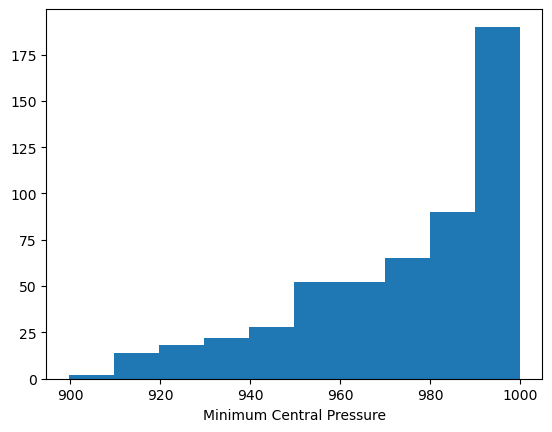

In [11]:
ds['center_pressure'].plot.hist()
plt.xlabel('Minimum Central Pressure')

Text(20, 60000000, 'Skewness :[-1.26]')

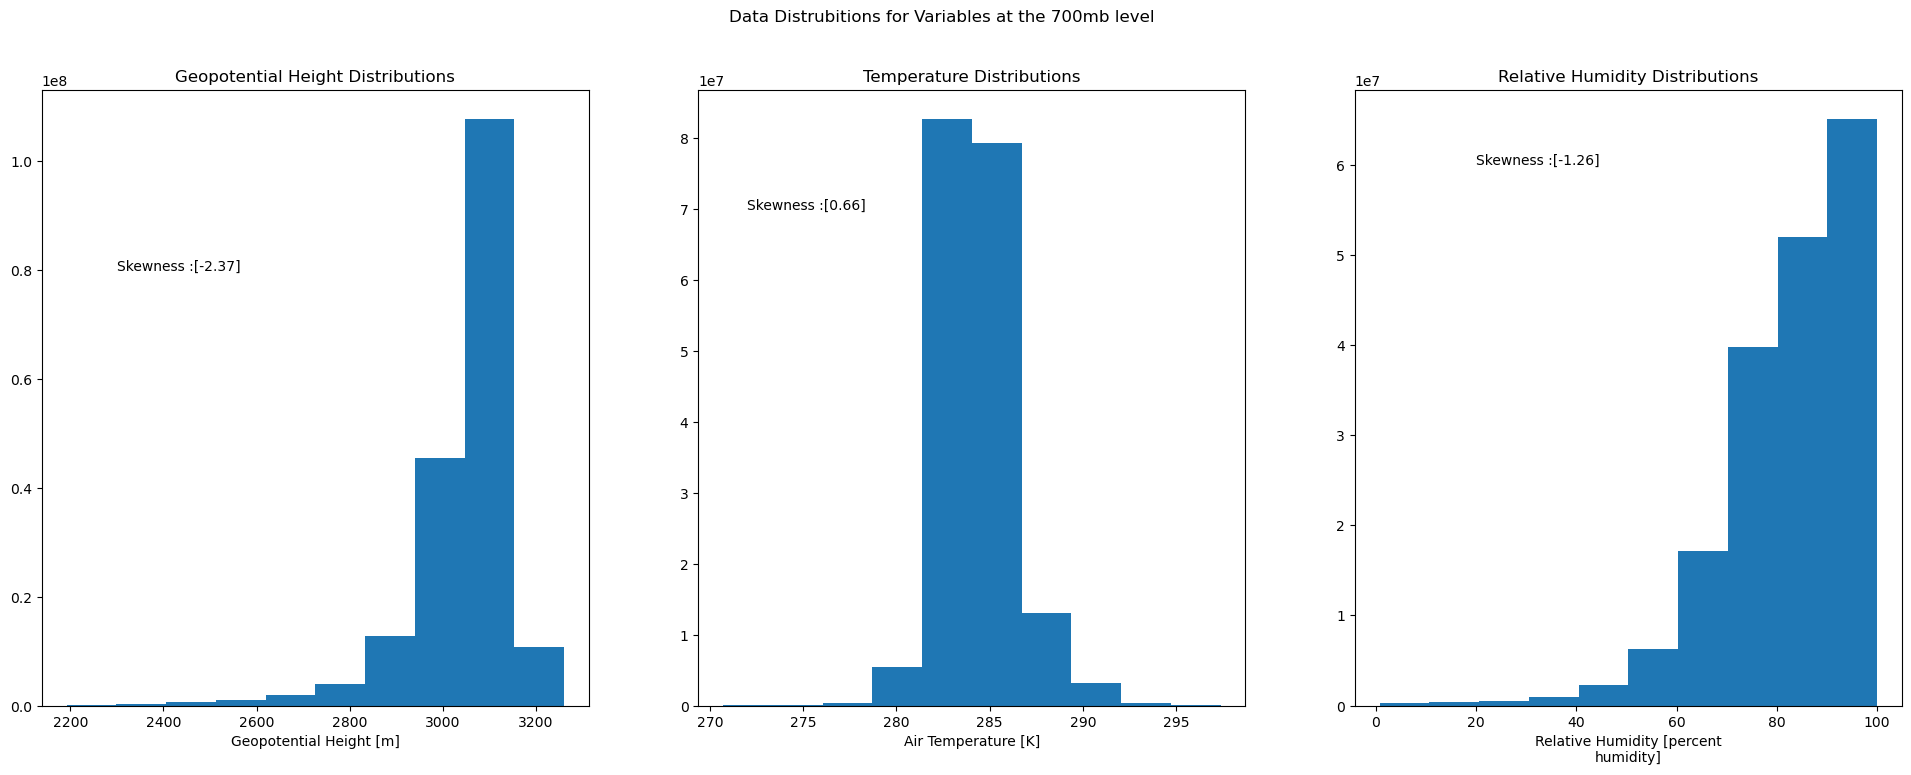

In [12]:
# Deciding on scalers

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))

ds_clean['gh'].isel(levels = lvl_700mb_ivalue).plot.hist(ax = ax[0])
ds_clean['t'].isel(levels = lvl_700mb_ivalue).plot.hist(ax = ax[1])
ds_clean['rh'].isel(levels = lvl_700mb_ivalue).plot.hist(ax = ax[2])


ax[0].set_title('Geopotential Height Distributions')
ax[1].set_title('Temperature Distributions')
ax[2].set_title('Relative Humidity Distributions')
fig.suptitle('Data Distrubitions for Variables at the 700mb level')


t_data_700 = ds_clean['t'].isel(levels = lvl_700mb_ivalue).values.reshape(-1,1)
rh_data_700 = ds_clean['rh'].isel(levels = lvl_700mb_ivalue).values.reshape(-1,1)
gh_data_700 = ds_clean['gh'].isel(levels = lvl_700mb_ivalue).values.reshape(-1,1)

gh_skew = scipy.stats.skew(gh_data_700)
t_skew = scipy.stats.skew(t_data_700)
rh_skew = scipy.stats.skew(rh_data_700)

ax[0].text(x = 2300, y = .8*10**8,  s = f'Skewness :{np.round(gh_skew,2)}')
ax[1].text(x = 272, y = 7 * 10**7, s = f'Skewness :{np.round(t_skew,2)}')
ax[2].text(x = 20, y = 6 * 10**7, s = f'Skewness :{np.round(rh_skew,2)}')

In [13]:
# Normalizing the Data
scaler = StandardScaler()

t_data_700 = ds_clean['t'].isel(levels = lvl_700mb_ivalue).values.reshape(-1,1)
scaled_t_data_700 = scaler.fit_transform(t_data_700).reshape(ds_clean['t'].isel(levels = lvl_700mb_ivalue).shape)

rh_data_700 = ds_clean['rh'].isel(levels = lvl_700mb_ivalue).values.reshape(-1,1)
scaled_rh_data_700 = power_transform(rh_data_700).reshape(ds_clean['rh'].isel(levels = lvl_700mb_ivalue).shape)

gh_data_700 = ds_clean['gh'].isel(levels = lvl_700mb_ivalue).values.reshape(-1,1)
scaled_gh_data_700 = power_transform(gh_data_700).reshape(ds_clean['gh'].isel(levels = lvl_700mb_ivalue).shape)


In [14]:
gh_data_700 = ds_clean['gh'].isel(levels = lvl_700mb_ivalue).values
rh_data_700 = ds_clean['rh'].isel(levels = lvl_700mb_ivalue).values
t_data_700 = ds_clean['t'].isel(levels = lvl_700mb_ivalue).values

Text(-2, 35000000.0, 'Skewness :[-0.18]')

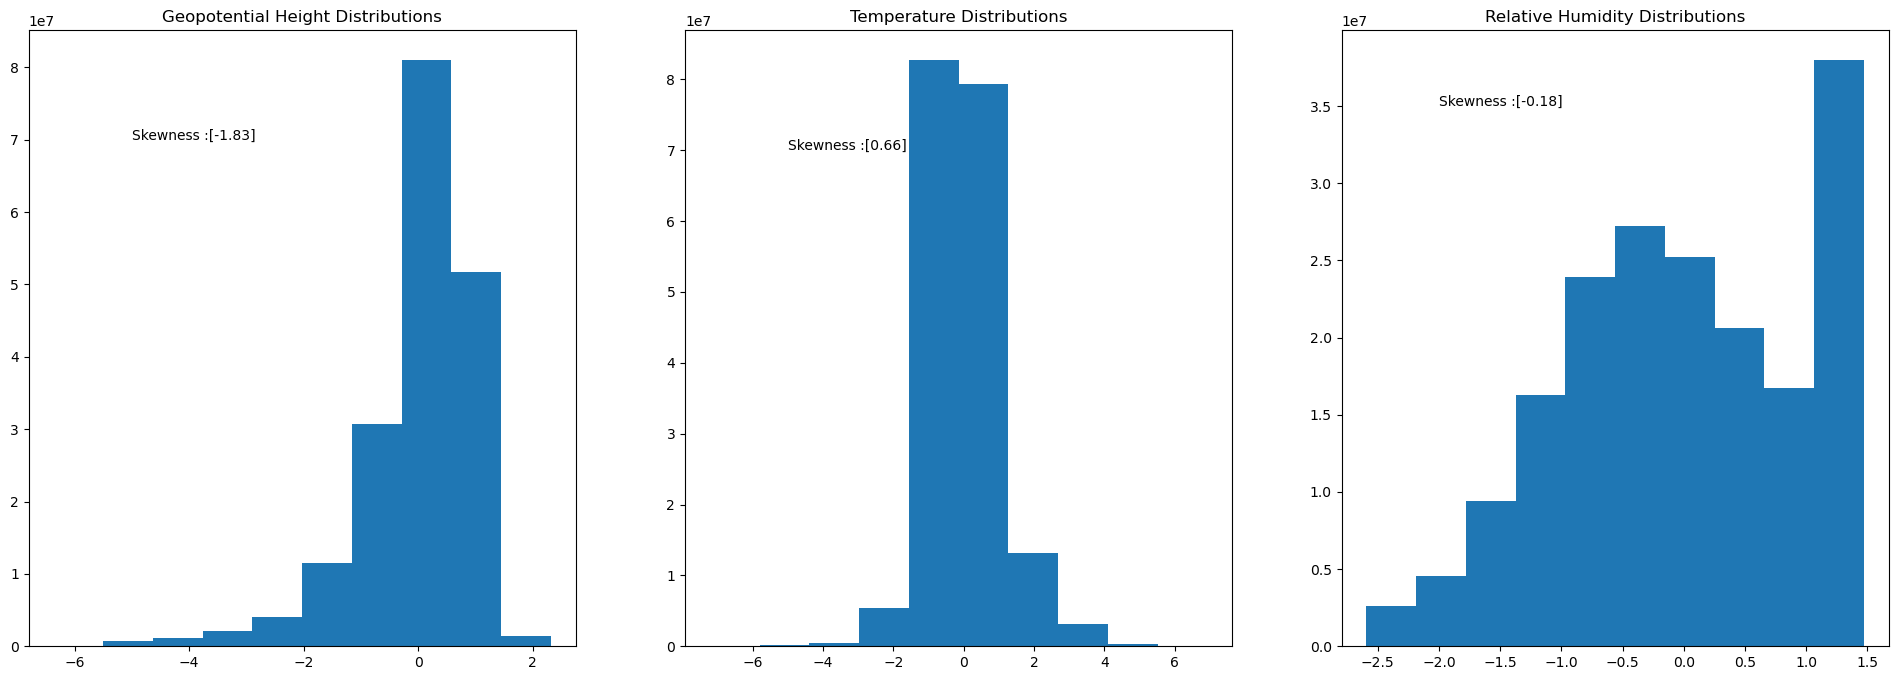

In [15]:

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))

ax[0].hist(scaled_gh_data_700.reshape(-1,1))
ax[1].hist(scaled_t_data_700.reshape(-1,1))
ax[2].hist(scaled_rh_data_700.reshape(-1,1))

ax[0].set_title('Geopotential Height Distributions')
ax[1].set_title('Temperature Distributions')
ax[2].set_title('Relative Humidity Distributions')

gh_skew = scipy.stats.skew(scaled_gh_data_700.reshape(-1,1))
t_skew = scipy.stats.skew(scaled_t_data_700.reshape(-1,1))
rh_skew = scipy.stats.skew(scaled_rh_data_700.reshape(-1,1))

ax[0].text(x = -5, y = 7*10**7,  s = f'Skewness :{np.round(gh_skew,2)}')
ax[1].text(x = -5, y = 7 * 10**7, s = f'Skewness :{np.round(t_skew,2)}')
ax[2].text(x = -2, y = 3.5 * 10**7, s = f'Skewness :{np.round(rh_skew,2)}')


In [16]:
# indexes based on pressure

ts = ds.where((ds['max_wind'] > 17.49) & (ds['max_wind'] < 32.94)).dropna(dim = 'valid_time')
cat1 = ds.where((ds['max_wind'] >= 17.49) & (ds['max_wind'] < 42.7)).dropna(dim = 'valid_time')
cat2 = ds.where((ds['max_wind'] >= 42.7) & (ds['max_wind'] < 49.39)).dropna(dim = 'valid_time')
cat3 = ds.where((ds['max_wind'] >= 49.39) & (ds['max_wind'] < 58.13)).dropna(dim = 'valid_time')
cat4 = ds.where((ds['max_wind'] >= 58.13) & (ds['max_wind'] < 70.48)).dropna(dim = 'valid_time')
cat5 = ds.where((ds['max_wind'] >= 70.48)).dropna(dim = 'valid_time')


In [17]:
#creating composites based on pressure ranges

gh_ts = ts['gh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
t_ts = ts['t'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
rh_ts = ts['rh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
gh_cat1 = cat1['gh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
t_cat1 = cat1['t'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
rh_cat1 = cat1['rh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
gh_cat2 = cat2['gh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
t_cat2 = cat2['t'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
rh_cat2 = cat2['rh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
gh_cat3 = cat3['gh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
t_cat3 = cat3['t'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
rh_cat3 = cat3['rh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
gh_cat4 = cat4['gh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
t_cat4 = cat4['t'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
rh_cat4 = cat4['rh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
gh_cat5 = cat5['gh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
t_cat5 = cat5['t'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
rh_cat5 = cat5['rh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')


Text(0.5, 0.98, 'Tropical Cyclone Variable Composites based on Minimum Central Pressure')

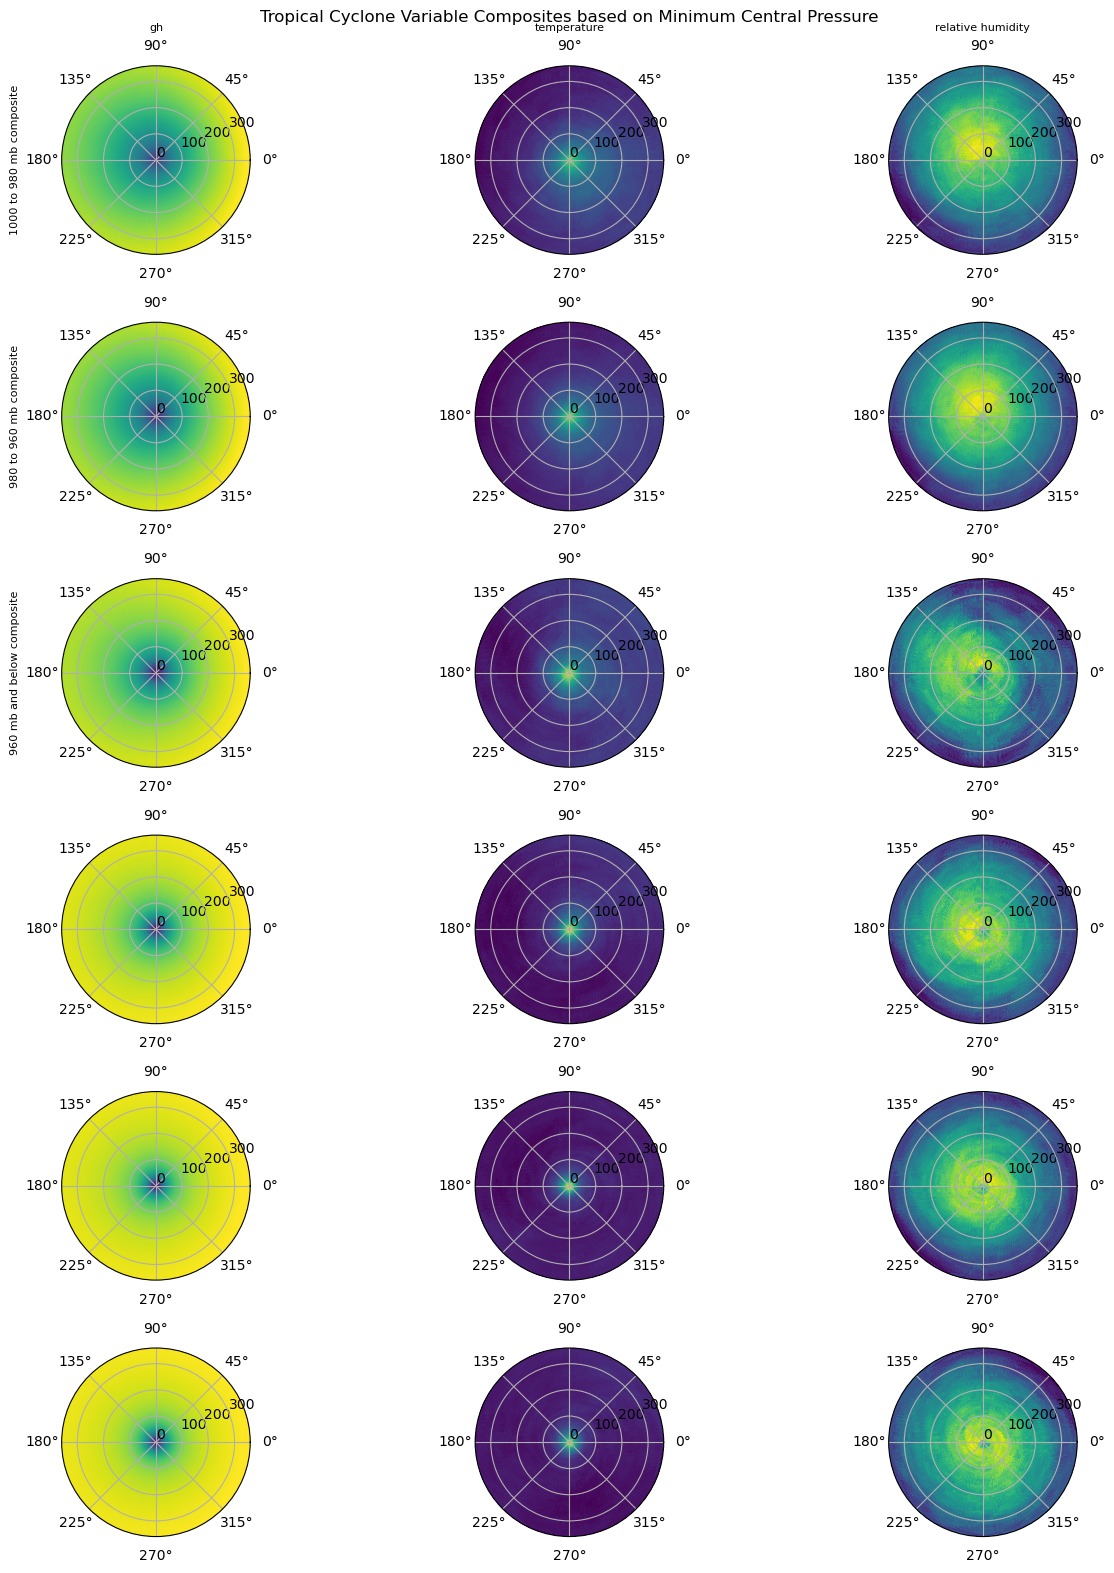

In [ ]:
fig, ax = plt.subplots(nrows= 6, ncols=3, figsize=(16, 16),subplot_kw={'projection': 'polar'})

angle, radius = ds.angle.values, ds.radius.values

R, Theta = np.meshgrid(radius, angle)


ax[0,0].pcolormesh(R, Theta, gh_ts)
ax[0,1].pcolormesh(R, Theta, t_ts)
ax[0,2].pcolormesh(R, Theta, rh_ts)
ax[1,0].pcolormesh(R, Theta, gh_cat1)
ax[1,1].pcolormesh(R, Theta, t_cat1)
ax[1,2].pcolormesh(R, Theta, rh_cat1)
ax[2,0].pcolormesh(R, Theta, gh_cat2)
ax[2,1].pcolormesh(R, Theta, t_cat2)
ax[2,2].pcolormesh(R, Theta, rh_cat2)
ax[3,0].pcolormesh(R, Theta, gh_cat3)
ax[3,1].pcolormesh(R, Theta, t_cat3)
ax[3,2].pcolormesh(R, Theta, rh_cat3)
ax[4,0].pcolormesh(R, Theta, gh_cat4)
ax[4,1].pcolormesh(R, Theta, t_cat4)
ax[4,2].pcolormesh(R, Theta, rh_cat4)
ax[5,0].pcolormesh(R, Theta, gh_cat5)
ax[5,1].pcolormesh(R, Theta, t_cat5)
ax[5,2].pcolormesh(R, Theta, rh_cat5)

ax[0,0].set_ylabel('Tropical Storm', fontsize = 8, labelpad = 30)
ax[1,0].set_ylabel('Category 1', fontsize = 8, labelpad = 30)
ax[2,0].set_ylabel('Category 2', fontsize = 8, labelpad = 30)
ax[3,0].set_ylabel('Category 3', fontsize = 8, labelpad = 30)
ax[4,0].set_ylabel('Category 4', fontsize = 8, labelpad = 30)
ax[5,0].set_ylabel('Category 5', fontsize = 8, labelpad = 30)

ax[0,0].set_title('gh', fontsize = 8)
ax[0,1].set_title('temperature', fontsize = 8)
ax[0,2].set_title('relative humidity', fontsize = 8)

fig.set_tight_layout(tight = True)
fig.suptitle('Tropical Cyclone Variable Composites based on Tropical Cyclone Category')

Calculating weights and constructing EOFs

In [19]:
max_range = 250.0
range_step = 0.5
angle_step = 0.5
range_gates = np.arange(0.0, max_range + range_step, range_step)

areas = []

for i, r in enumerate(range_gates):
    
    area = (angle_step/360) * np.pi * ((r + range_step)**2 - r**2)
    areas.append(area)

area_weight = areas/np.max(areas)

In [20]:
msolver = MultivariateEof([scaled_gh_data_700, scaled_t_data_700, scaled_rh_data_700], weights = [area_weight, area_weight, area_weight])
gh_eof, t_eof, rh_eof = msolver.eofsAsCorrelation(neofs=10)

In [21]:
multi_pcs = msolver.pcs(npcs = 3)

Text(0.5, 0.98, 'First 3 EOFs for a Multivariate EOF consisting of gh, Temp, and RH')

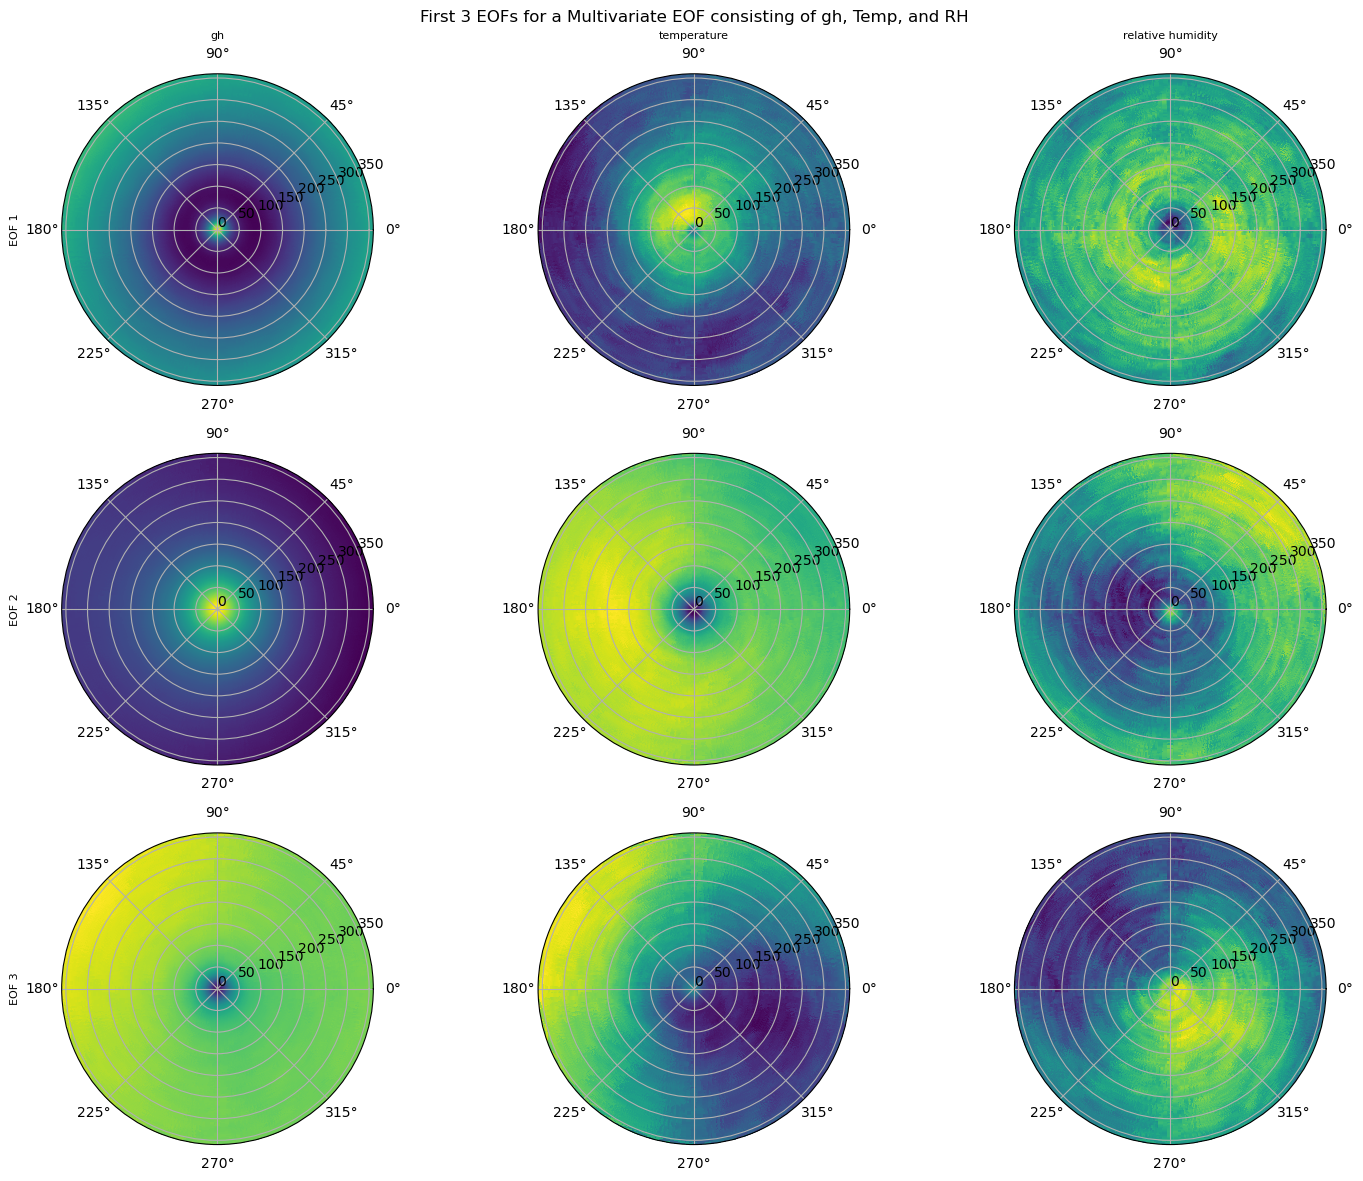

In [22]:
fig, ax = plt.subplots(nrows= 3, ncols=3, figsize=(16, 12),subplot_kw={'projection': 'polar'})

R, Theta = np.meshgrid(radius, angle)


ax[0,0].pcolormesh(R, Theta, gh_eof[0,:,:])
ax[0,1].pcolormesh(R, Theta, t_eof[0,:,:])
ax[0,2].pcolormesh(R, Theta, rh_eof[0,:,:])
ax[1,0].pcolormesh(R, Theta, gh_eof[1,:,:])
ax[1,1].pcolormesh(R, Theta, t_eof[1,:,:])
ax[1,2].pcolormesh(R, Theta, rh_eof[1,:,:])
ax[2,0].pcolormesh(R, Theta, gh_eof[2,:,:])
ax[2,1].pcolormesh(R, Theta, t_eof[2,:,:])
ax[2,2].pcolormesh(R, Theta, rh_eof[2,:,:])

ax[0,0].set_ylabel('EOF 1', fontsize = 8, labelpad = 30)
ax[1,0].set_ylabel('EOF 2', fontsize = 8, labelpad = 30)
ax[2,0].set_ylabel('EOF 3', fontsize = 8, labelpad = 30)

ax[0,0].set_title('gh', fontsize = 8)
ax[0,1].set_title('temperature', fontsize = 8)
ax[0,2].set_title('relative humidity', fontsize = 8)

fig.set_tight_layout(tight = True)
fig.suptitle('First 3 EOFs for a Multivariate EOF consisting of gh, Temp, and RH')

Text(0.5, 0, 'EOF number')

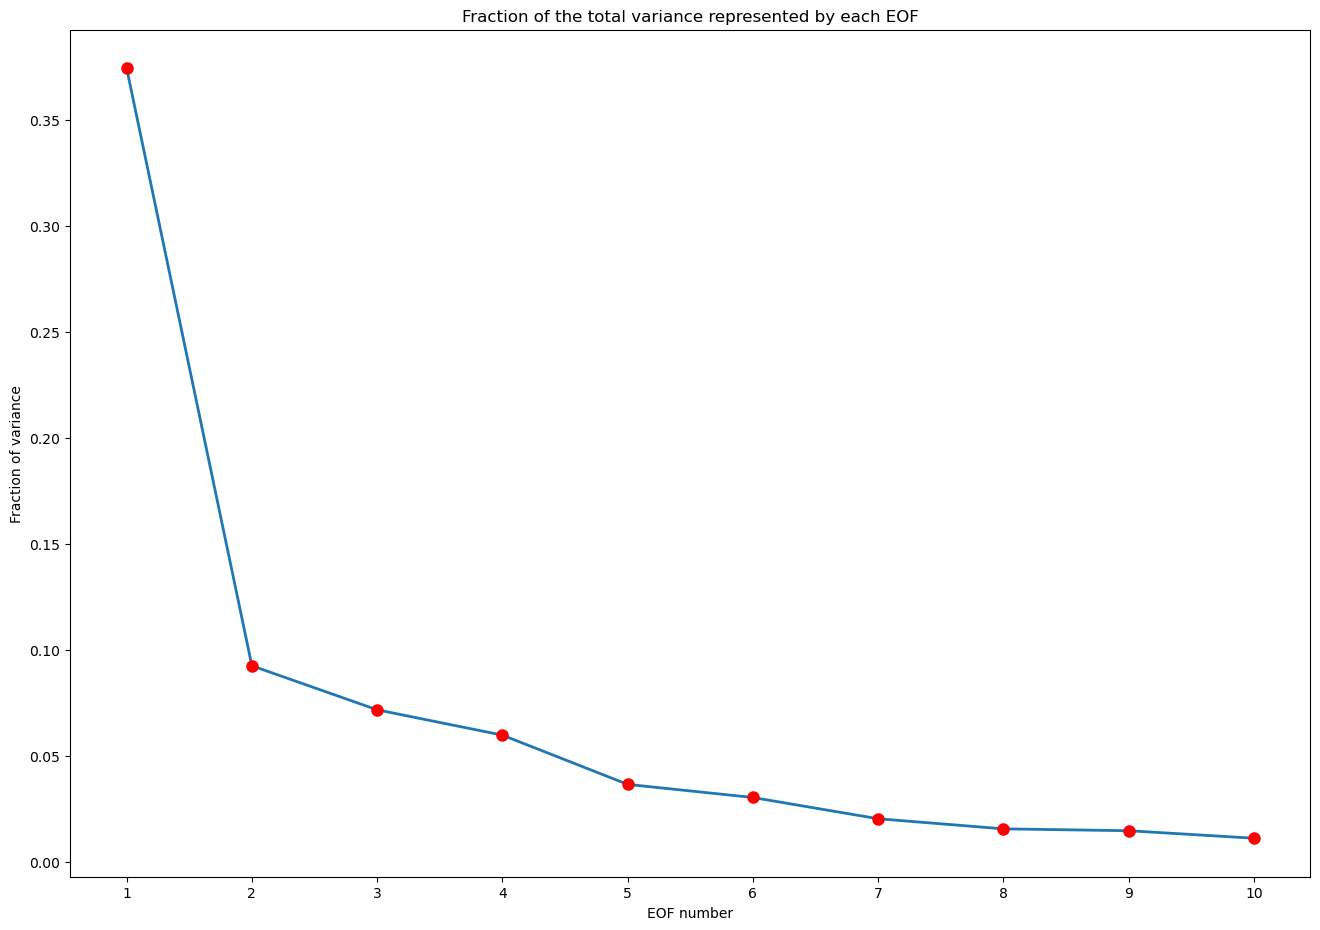

In [23]:
# Looking at the Variance

varfrac = msolver.varianceFraction()

# Plot the fraction of variance explained by each EOF

plt.figure(figsize = (16,11))
eof_num = range(1,11)
plt.plot(eof_num, varfrac[0:10], linewidth = "2")
plt.plot(eof_num, varfrac[0:10], linestyle = "None", marker = "o", color = "r", markersize = 8)
plt.xticks(range(1,11))
plt.title("Fraction of the total variance represented by each EOF")
plt.ylabel("Fraction of variance")
plt.xlabel("EOF number")

In [24]:
lin_model = LinearRegression()

multi_eof_lm = lin_model.fit(multi_pcs, ds_clean['max_wind'].values)
multi_scores = cross_val_score(lin_model, multi_pcs, ds_clean['max_wind'].values, scoring = 'neg_mean_squared_error', cv = 7)


multi_rmse_scores = np.sqrt(-multi_scores)
print("RMSE scores: ", multi_rmse_scores)
print("Mean RMSE: ", multi_rmse_scores.mean())
print("RMSE Std: ", multi_rmse_scores.std())

RMSE scores:  [ 8.85859124 14.70434664  9.8630816   9.63841152  6.31980549  7.01937927
 11.79281688]
Mean RMSE:  9.742347520432125
RMSE Std:  2.6392805977204725


In [25]:
lin_model = LinearRegression()

multi_eof_lm = lin_model.fit(multi_pcs, ds_clean['center_pressure'].values)
multi_scores = cross_val_score(lin_model, multi_pcs, ds_clean['center_pressure'].values, scoring = 'neg_mean_squared_error', cv = 7)


multi_rmse_scores = np.sqrt(-multi_scores)
print("RMSE scores: ", multi_rmse_scores)
print("Mean RMSE: ", multi_rmse_scores.mean())
print("RMSE Std: ", multi_rmse_scores.std())

RMSE scores:  [ 7.43251048 13.21728394  9.11354396  9.93772057  6.45531478 10.02435801
 12.34005193]
Mean RMSE:  9.788683382584692
RMSE Std:  2.2507537818619396


EOF as a function of Geopotential Height, Temperature, and Relative Humidity Single Variate Regressions

In [26]:
t_solver = Eof(scaled_t_data_700, weights = area_weight)
t_only_eof = t_solver.eofsAsCorrelation(neofs = 10)
t_only_pcs = t_solver.pcs(npcs = 3)


In [27]:
gh_solver = Eof(scaled_gh_data_700, weights = area_weight)
gh_only_eof = gh_solver.eofsAsCorrelation(neofs = 10)
gh_only_pcs = gh_solver.pcs(npcs = 3)

In [28]:
rh_solver = Eof(scaled_rh_data_700, weights = area_weight)
rh_only_eof = rh_solver.eofsAsCorrelation(neofs = 10)
rh_only_pcs = rh_solver.pcs(npcs = 3)

Examining Single Variate EOFs of each variable

Text(0.5, 0.98, 'First 3 EOFs for 3 single-variate EOFs consisting of gh, Temp, and RH')

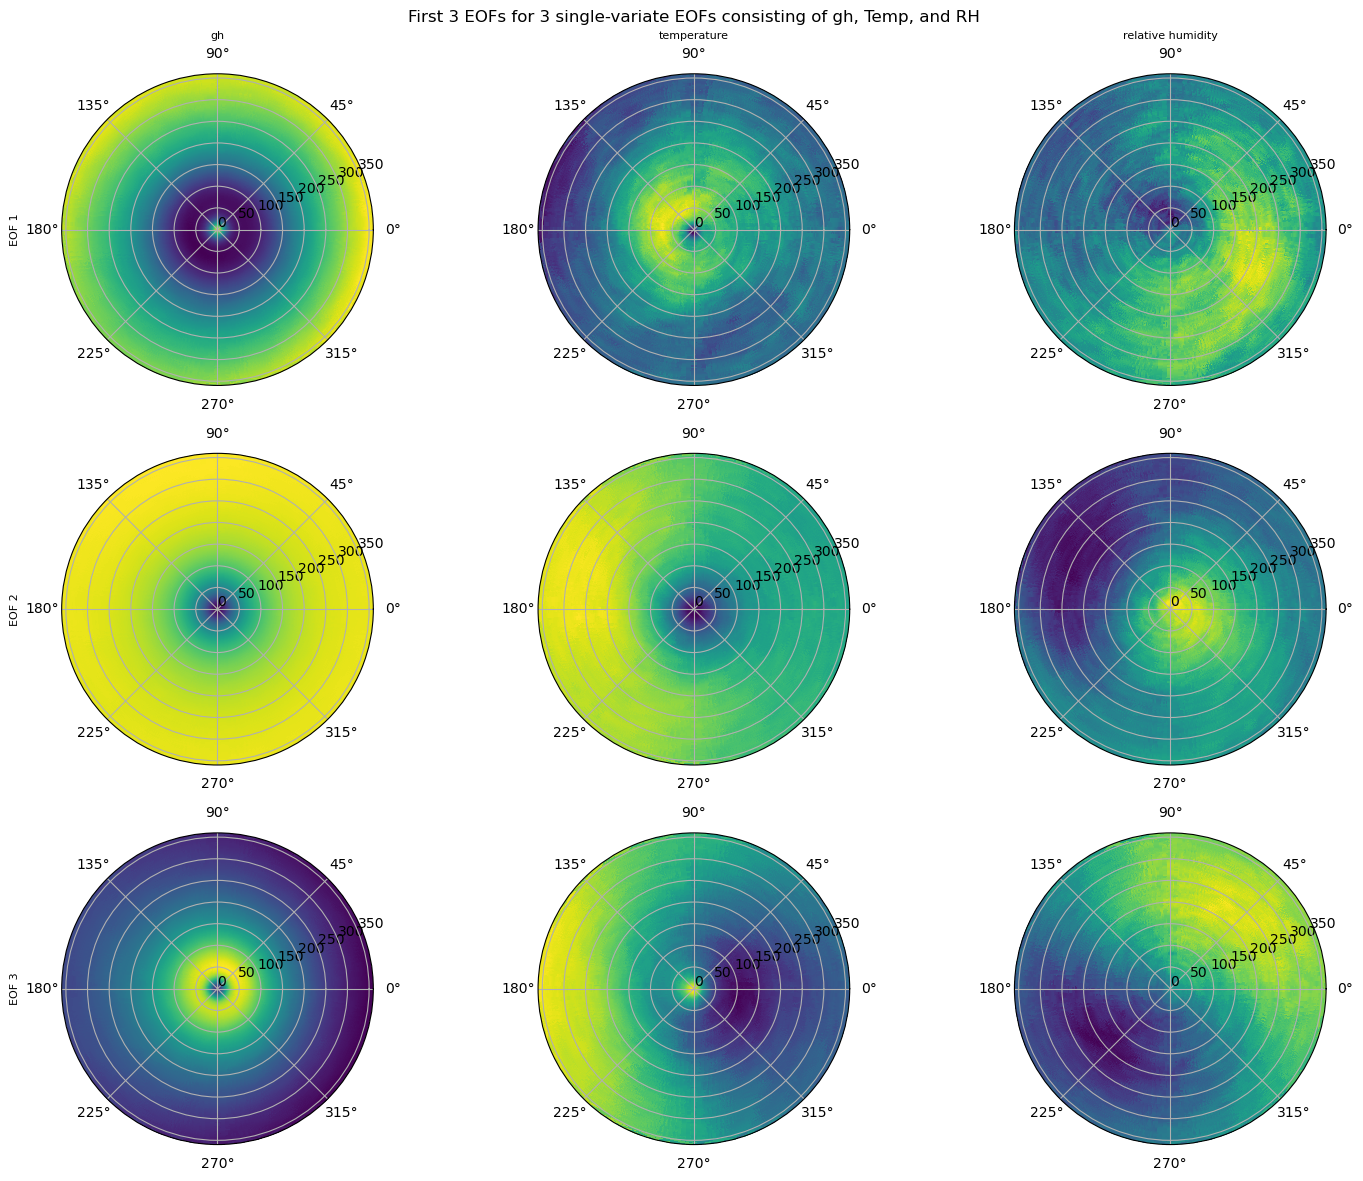

In [29]:
fig, ax = plt.subplots(nrows= 3, ncols=3, figsize=(16, 12),subplot_kw={'projection': 'polar'})

R, Theta = np.meshgrid(radius, angle)


ax[0,0].pcolormesh(R, Theta, gh_only_eof[0,:,:])
ax[0,1].pcolormesh(R, Theta, t_only_eof[0,:,:])
ax[0,2].pcolormesh(R, Theta, rh_only_eof[0,:,:])
ax[1,0].pcolormesh(R, Theta, gh_only_eof[1,:,:])
ax[1,1].pcolormesh(R, Theta, t_only_eof[1,:,:])
ax[1,2].pcolormesh(R, Theta, rh_only_eof[1,:,:])
ax[2,0].pcolormesh(R, Theta, gh_only_eof[2,:,:])
ax[2,1].pcolormesh(R, Theta, t_only_eof[2,:,:])
ax[2,2].pcolormesh(R, Theta, rh_only_eof[2,:,:])

ax[0,0].set_ylabel('EOF 1', fontsize = 8, labelpad = 30)
ax[1,0].set_ylabel('EOF 2', fontsize = 8, labelpad = 30)
ax[2,0].set_ylabel('EOF 3', fontsize = 8, labelpad = 30)

ax[0,0].set_title('gh', fontsize = 8)
ax[0,1].set_title('temperature', fontsize = 8)
ax[0,2].set_title('relative humidity', fontsize = 8)

fig.set_tight_layout(tight = True)
fig.suptitle('First 3 EOFs for 3 single-variate EOFs consisting of gh, Temp, and RH')

## 3 Single Variate EOFS in a Multiple-Linear Regression



Skill predicting Max Wind

In [30]:
gh_t_rh_pcs = np.concatenate([gh_only_pcs, t_only_pcs, rh_only_pcs], axis = 1)
lin_model = LinearRegression()

single_eof_lm_mw = lin_model.fit(gh_t_rh_pcs, ds_clean['max_wind'].values)
single_scores_mw = cross_val_score(single_eof_lm_mw, gh_t_rh_pcs, ds_clean['max_wind'].values, scoring = 'neg_mean_squared_error', cv = 7)


single_rmse_scores_mw = np.sqrt(-single_scores_mw)
print("RMSE scores: ", single_rmse_scores_mw)
print("Mean RMSE: ", single_rmse_scores_mw.mean())
print("RMSE Std: ", single_rmse_scores_mw.std())

RMSE scores:  [6.24857116 6.03338764 5.14550134 3.43613841 4.37894079 6.72052776
 4.98802655]
Mean RMSE:  5.278727663262188
RMSE Std:  1.0620669586545832


In [31]:
feature_names = ['Geopotential Height EOF1', 'Geopotential Height EOF2', 'Geopotential Height EOF3', 
                 "Temperature EOF1", "Temperature EOF2", "Temperature EOF3", 
                 'Relative Humidity EOF1', 'Relative Humidity EOF2', 'Relative Humidity EOF3']



Skill predicting Minimum Central Pressure

In [32]:
gh_t_rh_pcs = np.concatenate([gh_only_pcs, t_only_pcs, rh_only_pcs], axis = 1)
lin_model = LinearRegression()

single_eof_lm_cmslp = lin_model.fit(gh_t_rh_pcs, ds_clean['center_pressure'].values)
single_scores_cmslp = cross_val_score(single_eof_lm_cmslp, gh_t_rh_pcs, ds_clean['center_pressure'].values, scoring = 'neg_mean_squared_error', cv = 7)


single_rmse_scores_cmslp = np.sqrt(-single_scores_cmslp)
print("RMSE scores: ", single_rmse_scores_cmslp)
print("Mean RMSE: ", single_rmse_scores_cmslp.mean())
print("RMSE Std: ", single_rmse_scores_cmslp.std())

RMSE scores:  [3.94488313 2.34040828 2.76529902 2.32549673 1.86316089 2.20157138
 2.32304638]
Mean RMSE:  2.537695115661053
RMSE Std:  0.6244976917114958


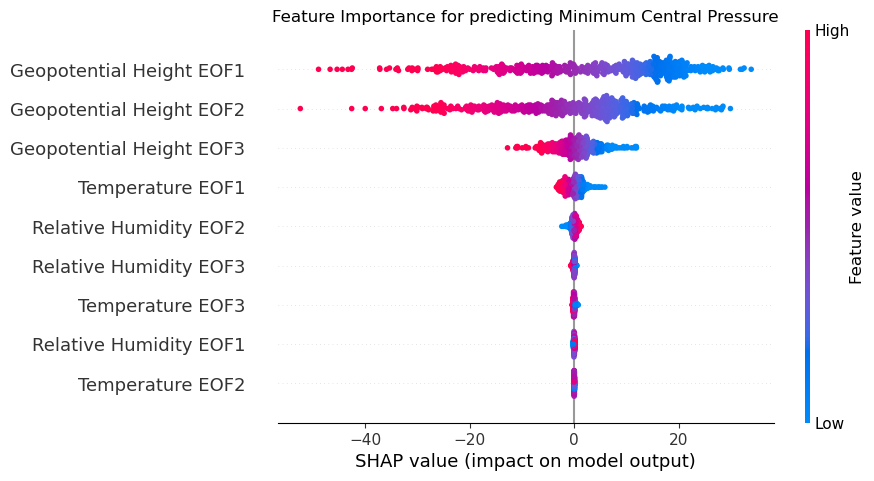

In [33]:
feature_names = ['Geopotential Height EOF1', 'Geopotential Height EOF2', 'Geopotential Height EOF3', 
                 "Temperature EOF1", "Temperature EOF2", "Temperature EOF3", 
                 'Relative Humidity EOF1', 'Relative Humidity EOF2', 'Relative Humidity EOF3']



explainer_cmslp = shap.Explainer(single_eof_lm_cmslp, gh_t_rh_pcs, feature_names = feature_names)
shap_values_cmslp = explainer_cmslp(gh_t_rh_pcs)

shap.plots.beeswarm(shap_values_cmslp, show = False)

plt.title('Feature Importance for predicting Minimum Central Pressure')
plt.show()


# explainer_mw = shap.Explainer(single_eof_lm_mw, gh_t_rh_pcs, feature_names = feature_names)
# shap_values_mw = explainer_mw(gh_t_rh_pcs)

# shap.plots.beeswarm(shap_values_mw, ax = ax[0], plot_size=None)

# plt.show()

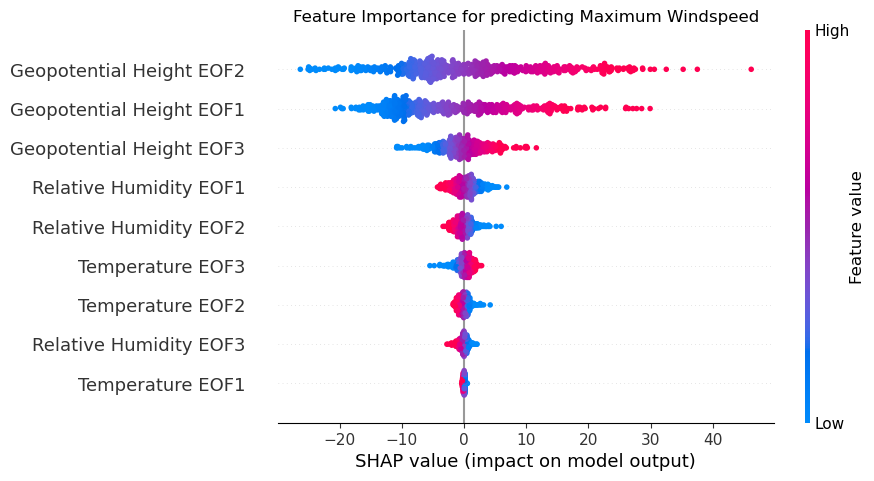

In [34]:
feature_names = ['Geopotential Height EOF1', 'Geopotential Height EOF2', 'Geopotential Height EOF3', 
                 "Temperature EOF1", "Temperature EOF2", "Temperature EOF3", 
                 'Relative Humidity EOF1', 'Relative Humidity EOF2', 'Relative Humidity EOF3']





explainer_mw = shap.Explainer(single_eof_lm_mw, gh_t_rh_pcs, feature_names = feature_names)
shap_values_mw = explainer_mw(gh_t_rh_pcs)

shap.plots.beeswarm(shap_values_mw, show = False)
plt.title('Feature Importance for predicting Maximum Windspeed')
plt.show()
